## <u> Data Modelling </u>

This notebook aim to implements a binary classification model to predict loan default risk using gradient boosted decision trees. The modeling workflow follows a systematic approach by splitting the dataset into training, validation, and test sets, conducting hyperparameter tuning via cross-validation on the training set, and evaluating final model performance on the test set. Given the class imbalance inherent to credit default datasets, appropriate evaluation metrics and sampling strategies are employed throughout the modeling process to ensure robust model assessment.

### <u> 1. Setup</u>

In [1]:
# Import necessary libraries
import pandas as pd, sys
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix,
    classification_report, precision_recall_curve
)

import matplotlib.pyplot as plt
import numpy as np
import joblib

In [2]:
# Import final dataset
home_credit = pd.read_csv('../data/processed/home_credit_final.csv', index_col=0)

# Ensure categorical columns are of type 'category'
cat_cols = home_credit.select_dtypes(include="object").columns
for col in cat_cols:
    home_credit[col] = home_credit[col].astype("category")

home_credit.head(3)

,EXT_SOURCE_3,EXT_SOURCE_1,EXT_SOURCE_2,YEARS_EMPLOYED,YEARS_BIRTH,OCCUPATION_TYPE,ORGANIZATION_TYPE,NAME_INCOME_TYPE,REG_CITY_NOT_WORK_CITY,YEARS_LAST_PHONE_CHANGE,...,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,FLAG_OWN_CAR,CODE_GENDER,AMT_ANNUITY,prev_cnt_revolving_refused,prev_has_history,prev_cnt_revolving_canceled,prev_cnt_cash_refused,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
149977,0.567379,NaN,0.318931,13.8,47.1,Laborers,Industry: type 7,Working,0,5.3,...,2,14,1,M,37800.0,0,1,0,0,0
149261,0.197475,0.37669,0.121854,1.2,35.7,Private service staff,Self-employed,Working,1,0.2,...,2,9,0,F,27652.5,0,1,0,1,1
451117,NaN,NaN,0.162192,24.2,42.3,Laborers,Industry: type 11,Working,0,2.4,...,2,12,0,F,11101.5,0,1,0,0,0


### <u> 2. Modelling Pipeline</u>

Given the early inspection of the variables, **gradient boosted trees** were adopted as the model type. The primary reason lies in the fact that missing values in this dataset carry meaningful predictive signal, and the feature set comprises a mix of numerical and categorical variables. Both characteristics are handled natively by gradient boosted trees without requiring any preprocessing.

Alternative approaches such as logistic regression, support vector machines, or deep neural networks were considered but ultimately set aside. These methods would have required one-hot encoding of the categorical variables and imputation of the missing values across the five features in question, effectively introducing synthetic data into variables that are highly correlated with the target response. This trade-off risks distorting the very patterns we aim to capture.

Among the two leading state-of-the-art implementations, LightGBM and XGBoost, the former was selected given the medium-large sample size of the training set, along with its faster training speed and more efficient memory usage when processing large feature spaces. These properties make **LightGBM** particularly well suited to our setting, where the dataset comprises approximately 300,000 observations and the modeling pipeline is expected to be iterated upon multiple times during the tuning phase.

#### <u> 2.1 Train and Test Set</u>

A 80/20 stratified split was adopted to allocate the largest share of observations to training, while ensuring the 8% default rate is preserved across both sets through stratification on the response variable. The training set is used to train the model and, under cross validation, also to tune the hyperparameters. The test set is used to assess the model's ability to generalise on unseen data. This two-way structure prevents information leakage by keeping the test set completely isolated throughout the entire modelling process.

In [3]:
X = home_credit.drop(columns=['TARGET'])
y = home_credit['TARGET']

# 80/20 Stratified split on response variable
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12, stratify=y
)

# Check ratios and sizes
for name, target in [('Train', y_train), ('Evaluation', y_test)]:
    print(f"{name:>12} | Size: {len(target):>6} | Default rate: {target.mean():.4f}")


       Train | Size: 246008 | Default rate: 0.0807
  Evaluation | Size:  61503 | Default rate: 0.0807


#### <u> 2.2 Hyperparameters Search</u>

In order to find the optimal hyperparameters for the LightGBM model, a cross validation procedure is applied over the training set. While a deeper search of the hyperparameter space is possible, a light but context-driven approach is adopted here to avoid an inefficient and blind exploration. In terms of evaluation metric, AUC is used as the scoring criterion given the imbalanced nature of the response variable. In this context AUC measures the model's overall ability to separate defaults from non-defaults across all possible classification thresholds, making it the most appropriate metric at this stage. The selection of the optimal threshold is then based on the cost asymmetry between false negatives and false positives will be addressed during the final evaluation on the test set.

In [4]:
# Define base parameters for the model
base_params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'random_state': 12,
    'min_child_samples': 50
}


# Light grid search parameters
param_grid = {
    'n_estimators': [100, 200, 350],
    'learning_rate': [0.05, 0.1],
    'scale_pos_weight': [(1 - 0.08) / 0.08, 1], # 11.5 vs 1 to address class imbalance
    'num_leaves': [30, 60],
    'max_depth': [6, 8],
}

# Initialize StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

# Set up GridSearchCV over hyperparameters grid
grid_search = GridSearchCV(
    estimator=lgb.LGBMClassifier(**base_params),
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=2,
    verbose=1,
    return_train_score=True
)

In [ ]:
# Fit grid search
grid_search.fit(X_train, y_train)

# Print best score and parameters
print(f"Best AUC: {grid_search.best_score_:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")

# Save grid search results
# joblib.dump(grid_search, 'grid_search_lgbm.pkl')

#### <u> 2.3 Optimal Threshold</u>

To ensure no data leakage, the optimal threshold is estimated across the cross validation folds of the best configuration rather than on the test set. For each fold, the point on the ROC curve closest to (0, 1) is identified, as this represents the best trade-off between catching defaults and preserving good customers. The thresholds obtained across the five folds are then averaged to produce a single stable estimate, which is applied during the final evaluation on the test set.


In [5]:
# Load grid search results
grid_search = joblib.load('grid_search_lgbm.pkl')

# Set best paramters from grid search
best_model_params = grid_search.best_estimator_.get_params()
thresholds_per_fold = []

for train_idx, val_idx in cv.split(X_train, y_train):
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train model with best parameters
    model = lgb.LGBMClassifier(**best_model_params)
    model.fit(X_fold_train, y_fold_train)

    # Predict probabilities on the held-out fold
    y_fold_prob = model.predict_proba(X_fold_val)[:, 1]

    # Compute ROC and find optimal threshold
    fpr, tpr, thresh = roc_curve(y_fold_val, y_fold_prob)
    distances = np.sqrt(fpr**2 + (tpr - 1)**2)
    optimal_idx = np.argmin(distances)
    thresholds_per_fold.append(thresh[optimal_idx])

# Average threshold across folds
optimal_threshold = np.mean(thresholds_per_fold)

print(f"Threshold per fold: {thresholds_per_fold}")
print(f"Averaged Optimal Threshold: {optimal_threshold:.4f}")

Threshold per fold: [0.08038581460569101, 0.07336146162559902, 0.07663142734286, 0.07630651669996, 0.0773673668140089]
Averaged Optimal Threshold: 0.0768


#### <u> 2.4 Model evaluation</u>

In [6]:
# Predict default probabilities on test set using best model 
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Compute ROC AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# AUC
print(f"AUC on Test Set: {roc_auc:.4f}")

AUC on Test Set: 0.7582


Threshold from CV:         0.0768
Threshold from test curve: 0.0793


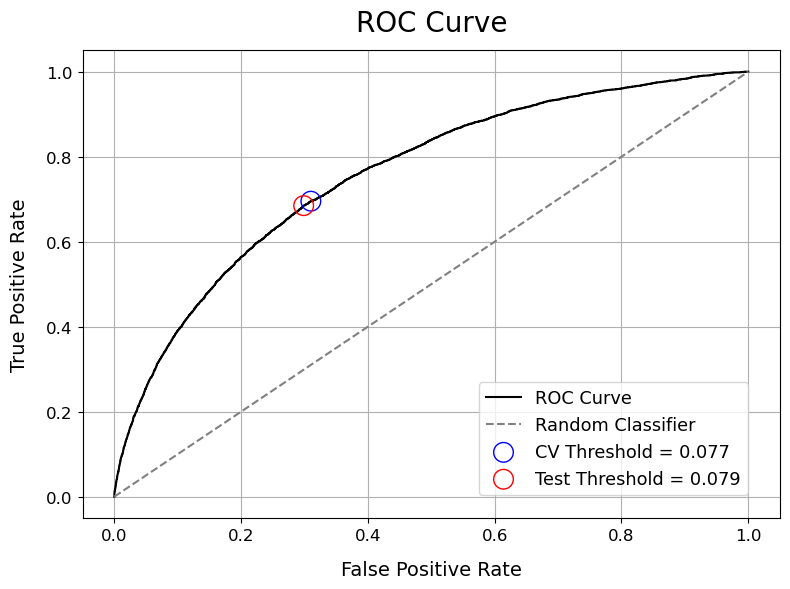

In [12]:
# Predict default probabilities on test set using best model 
y_prob = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

# Compute ROC AUC on test set
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Locate CV threshold on the test ROC curve 
optimal_idx_cv = np.argmin(np.abs(thresholds - optimal_threshold))

# Test curve threshold
distances = np.sqrt(fpr**2 + (tpr - 1)**2)
optimal_idx_test = np.argmin(distances)

print(f"Threshold from CV:         {optimal_threshold:.4f}")
print(f"Threshold from test curve: {thresholds[optimal_idx_test]:.4f}")

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='black', label=f'ROC Curve')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier')
plt.scatter(fpr[optimal_idx_cv], tpr[optimal_idx_cv], color='blue', s=200, zorder=5, marker= 'o', facecolors='none',
            label=f'CV Threshold = {optimal_threshold:.3f}')
plt.scatter(fpr[optimal_idx_test], tpr[optimal_idx_test], color='red', s=200, zorder=5, marker='o', facecolors='none',
            label=f'Test Threshold = {thresholds[optimal_idx_test]:.3f}')
plt.xlabel('False Positive Rate', labelpad=12.5, fontsize=14)
plt.ylabel('True Positive Rate', labelpad=12.5, fontsize=14)
plt.title('ROC Curve', fontsize=20, pad=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12.8, bbox_to_anchor=(0.967, 0.03))
plt.grid(True)
plt.tight_layout()
plt.savefig('../images/roc_curve_lgbm.png', dpi=600, bbox_inches='tight')
plt.show()

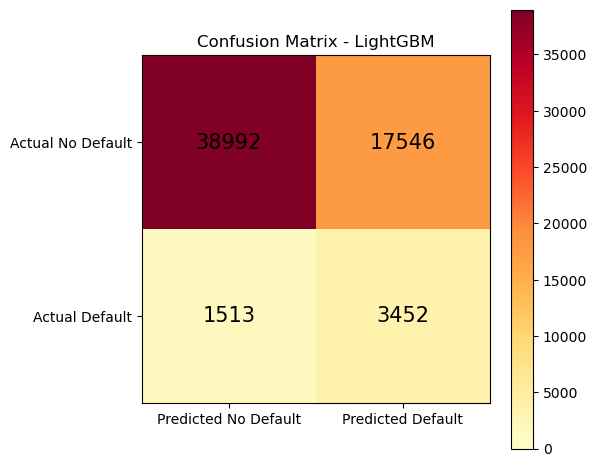

In [8]:
# Confusion matrix

# Assign predictions based on CV optimal threshold
y_pred = (y_prob >= optimal_threshold).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
plt.imshow(cm, cmap='YlOrRd', vmin=0, vmax=cm.max() * 1)
plt.colorbar()
plt.xticks([0, 1], ['Predicted No Default', 'Predicted Default'])
plt.yticks([0, 1], ['Actual No Default', 'Actual Default'])
plt.title('Confusion Matrix - LightGBM')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', fontsize=15)
plt.tight_layout()
plt.show()

In [10]:
# Classification report
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default'], digits=3))

# AUC
print(f"\nAUC on Test Set: {roc_auc:.4f}")

              precision    recall  f1-score   support

  No Default      0.963     0.690     0.804     56538
     Default      0.164     0.695     0.266      4965

    accuracy                          0.690     61503
   macro avg      0.564     0.692     0.535     61503
weighted avg      0.898     0.690     0.760     61503


AUC on Test Set: 0.7582


#### <u> 2.5 Feature importance</u>

In [11]:

# Extract the feature importnace from the best model
best_model = grid_search.best_estimator_
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

# Add rank column based on importance
importance_df['rank'] = range(1, len(importance_df) + 1)

# Save for PowerBI
importance_df.to_excel('../data/processed/feature_importance.xlsx', index=False)
print(importance_df)

                        feature  importance  rank
0             ORGANIZATION_TYPE        1498     1
1                  EXT_SOURCE_1         792     2
2                  EXT_SOURCE_3         726     3
3                  EXT_SOURCE_2         702     4
4                    AMT_CREDIT         661     5
5                   YEARS_BIRTH         580     6
6                   AMT_ANNUITY         523     7
7               OCCUPATION_TYPE         497     8
8                YEARS_EMPLOYED         483     9
9            YEARS_REGISTRATION         449    10
10             YEARS_ID_PUBLISH         422    11
11   REGION_POPULATION_RELATIVE         354    12
12      YEARS_LAST_PHONE_CHANGE         314    13
13                  OWN_CAR_AGE         281    14
14               bur_cnt_active         256    15
15      HOUR_APPR_PROCESS_START         238    16
16   prev_cnt_consumer_approved         219    17
17        prev_cnt_cash_refused         194    18
18                  CODE_GENDER         102    19


<u>**Comment:**</u>


By observing the ranked feature importances, `ORGANIZATION_TYPE` largely surpasses the `EXT_SOURCE` variables previously identified as strongest by the phi-k correlation analysis. The likely reason lies in the nature of decision tree modelling, which builds complex separations across the 42 categories of `ORGANIZATION_TYPE` through deeper splits, capturing patterns that the pairwise phi-k correlation was unable to detect. Other categorical variables such as `OCCUPATION_TYPE` follow a similar pattern. Overall, aside from a few FLAG variables at the bottom of the ranking, the model appears to extract meaningful signal from the majority of the features provided, justifying the feature engineering and selection work conducted in the earlier stages of the project.

#### <u> 2.5 Prediction dataframe</u>

In [ ]:
# Predictions on train set 
y_train_prob = grid_search.best_estimator_.predict_proba(X_train)[:, 1]

train_df = pd.DataFrame({
    'SK_ID_CURR': X_train.index,
    'actual': y_train.values,
    'predicted_probability': y_train_prob,
    'predicted_class': (y_train_prob >= optimal_threshold).astype(int),
    'split': 'train'
})

# Predictions on test set
test_df = pd.DataFrame({
    'SK_ID_CURR': X_test.index,
    'actual': y_test.values,
    'predicted_probability': y_prob,
    'predicted_class': (y_prob >= optimal_threshold).astype(int),
    'split': 'test'
})


# Merge train and test predictions
predictions_df = pd.concat([train_df, test_df], ignore_index=True)

# Export
predictions_df.to_csv('../data/processed/model_predictions.csv', index=False)